In [ ]:
# TODO: include start and end of feature, include prefix and suffix info

In [ ]:
# Read book: Data Without Labels (Manning Publ.)

In [ ]:
# https://python-charts.com/correlation/clustermap-seaborn/

In [13]:
import collections, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [14]:
path = '../data'

all_file_names = [
         'nouns_adjectives.csv', 
         'infa_qal.csv',
         'infc_qal_lamed_he.csv', 
         'infc_qal_triliteral.csv', 
         'niph_hiph_pe_yod.csv', 
         'ptca_qal.csv', 
         'ptcp_qal.csv',
         'hiphil_triliteral_with_hireq.csv'
]

In [15]:
def import_data(path: str, 
                files: list, 
                include_sp: bool):

    scroll_book_dict = collections.defaultdict(lambda: collections.defaultdict(list))

    for file in files:
        dat = pd.read_csv(os.path.join(path, file), sep='\t')

        feature_name = file.split('.')[0]
        print(feature_name)

        dat['book2'] = dat.book.str.replace('1_', '').str.replace('2_', '')

        if not include_sp:
            dat = dat[dat.scroll != 'SP']
    
        # split 1QIsaa in two halves
        dat['scroll2'] = [scr + '_I' if scr == '1Qisaa' and chapter < 34 else scr + '_II' if scr == '1Qisaa' and chapter >= 34 else scr for scr, chapter in zip(dat.scroll, dat.chapter)]
        
        if feature_name == 'hiphil_triliteral_with_hireq':
            dat = dat[dat.has_hireq == '1']

        # remove participles without o
        if feature_name == 'ptca_qal':
            dat = dat[~dat.lex.isin(['ML>[', 'JR>[', '>SP['])]

        # remove II-tsade verbs
        if feature_name == 'niph_hiph_pe_yod':
            dat = dat[~dat.lex.isin(['JY<[', 'JYG[', 'JYQ[', 'JYR[', 'JYT['])]
            
        if feature_name == 'nouns_adjectives':
            dat['lex_type'] = dat.lex + '_' + dat.type
            lex_vl_counts = pd.crosstab(dat.lex_type, dat.vowel_letter).T

            lex_vl = lex_vl_counts.idxmax()
            lex_vl_df = pd.DataFrame(lex_vl)
            lex_vl_df.columns = ['lex_vl']
            dat = pd.merge(dat, lex_vl_df, how='left', on=['lex_type'])

            dat.loc[dat['lex_vl'] == 'J', 'lex_vl'] = 'Y'

            # Remove aleph
            dat = dat[dat['lex_vl'].isin({'Y', 'W'})]
      
        for idx, row in dat.iterrows():
        
            scroll = row.scroll2
            book = row.book2
            lex = row.lex
            typ = row.type
            has_vl = str(row.has_vowel_letter)
       
            has_suffix = str(int(row.has_hloc) or int(row.has_nme) or int(row.has_prs))
        
            if feature_name == 'nouns_adjectives':
                #print(feature_name, typ, row.lex_vl, str(has_vl), has_suffix, row.lex, row.g_cons)
                spelling_info = '_'.join([feature_name, typ, row.lex_vl, str(has_vl), has_suffix])
                feature_info = (feature_name + '_' + typ + '_' + row.lex_vl, lex)
            else:
                spelling_info = '_'.join([feature_name, str(has_vl), has_suffix])
                feature_info = (feature_name + '_' + typ, lex)

        
            scroll_book_dict[scroll + '_' + book][feature_info].append(spelling_info)

    return scroll_book_dict
    

In [16]:
def prepare_features(scroll_book_dict, lex_cut_off):

    all_features = set()
    book_feature_counts = collections.defaultdict(int)

    for scr_book, feat_lex_dict in scroll_book_dict.items():
        features_in_one_book = collections.defaultdict(int)
    
        for (feature, lex), spelling_list in feat_lex_dict.items():
            feature_count = collections.Counter(spelling_list)
            all_features.update(spelling_list)
            for feature, count in feature_count.items():
                features_in_one_book[feature] += min(lex_cut_off, count)
           
            book_feature_counts[scr_book] = features_in_one_book
            
    sorted_features = sorted(list(all_features))
    return sorted_features, book_feature_counts

def prepare_features_in_df(document_cut_off):
    features = {}

    for scr_book, feature_counts in book_feature_counts.items():
        counts_list = []
        for feat in sorted_features:
            counts_list.append(feature_counts.get(feat, 0))
    
        if sum(counts_list) > document_cut_off:
            features[scr_book] = counts_list
    
    counts_df = pd.DataFrame(features).T
    counts_df.columns = sorted_features

    return counts_df

def remove_rare_features(counts_df, feature_cut_off):

    counts_df = counts_df[counts_df.columns[counts_df.sum() > feature_cut_off]]
    return counts_df

def divide_by_document_sums(counts_df):
    row_sums = counts_df.sum(axis=1)
    counts_norm_df = counts_df.divide(row_sums, axis='rows')
    return counts_norm_df

# Only nouns and adjectives

In [17]:
files = [
         'nouns_adjectives.csv'
]

LEX_CUT_OFF = 10
DOCUMENT_CUT_OFF = 50
FEATURE_CUT_OFF = 10

#file_names = [
#         'nouns_adjectives.csv', 
#         'infa_qal.csv',
#         'infc_qal_lamed_he.csv', 
#         'infc_qal_triliteral.csv', 
#         'niph_hiph_pe_yod.csv', 
#         'ptca_qal.csv', 
#         'ptcp_qal.csv',
#         'hiphil_triliteral_with_hireq.csv'
#]

scroll_book_dict = import_data(path, files, True)
sorted_features, book_feature_counts = prepare_features(scroll_book_dict, LEX_CUT_OFF)
counts_df = prepare_features_in_df(DOCUMENT_CUT_OFF)
counts_df = remove_rare_features(counts_df, FEATURE_CUT_OFF)
counts_norm_df_nouns_adjectives = divide_by_document_sums(counts_df)

nouns_adjectives


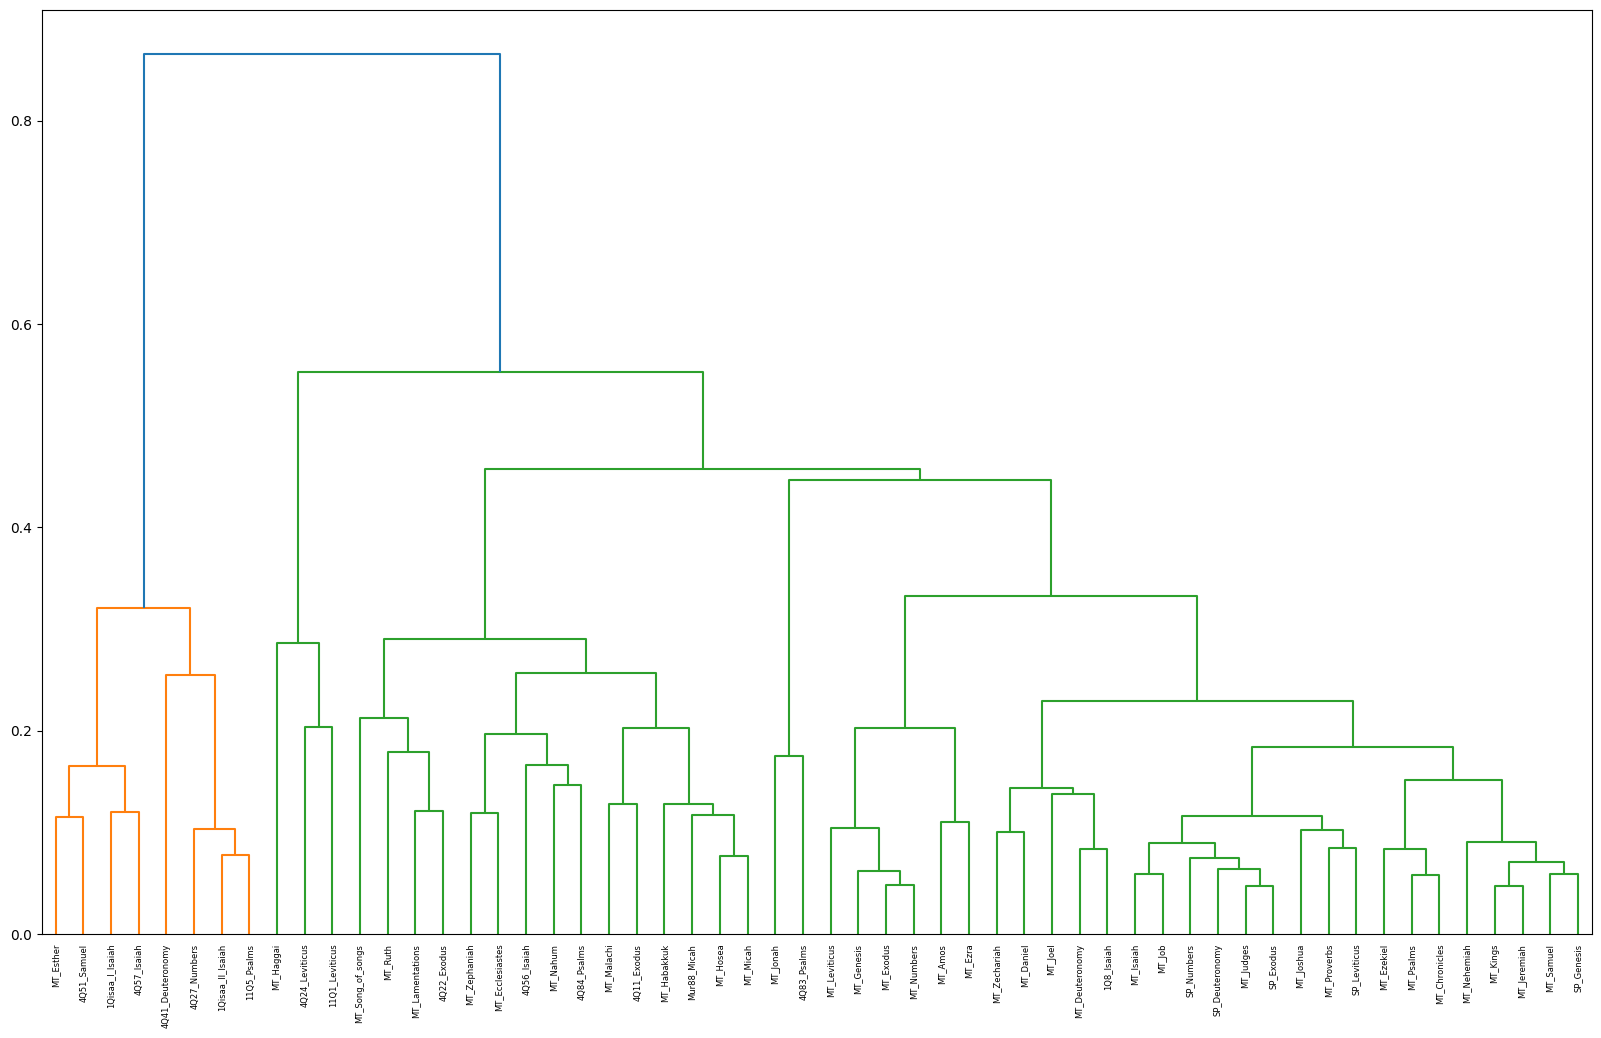

In [18]:
linkage_data = linkage(counts_norm_df_nouns_adjectives, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts_norm_df_nouns_adjectives.index)

plt.savefig(f'hierarch_clust_counts_norm_dendrogram_nouns_adjectives_lex_cut_off_{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')

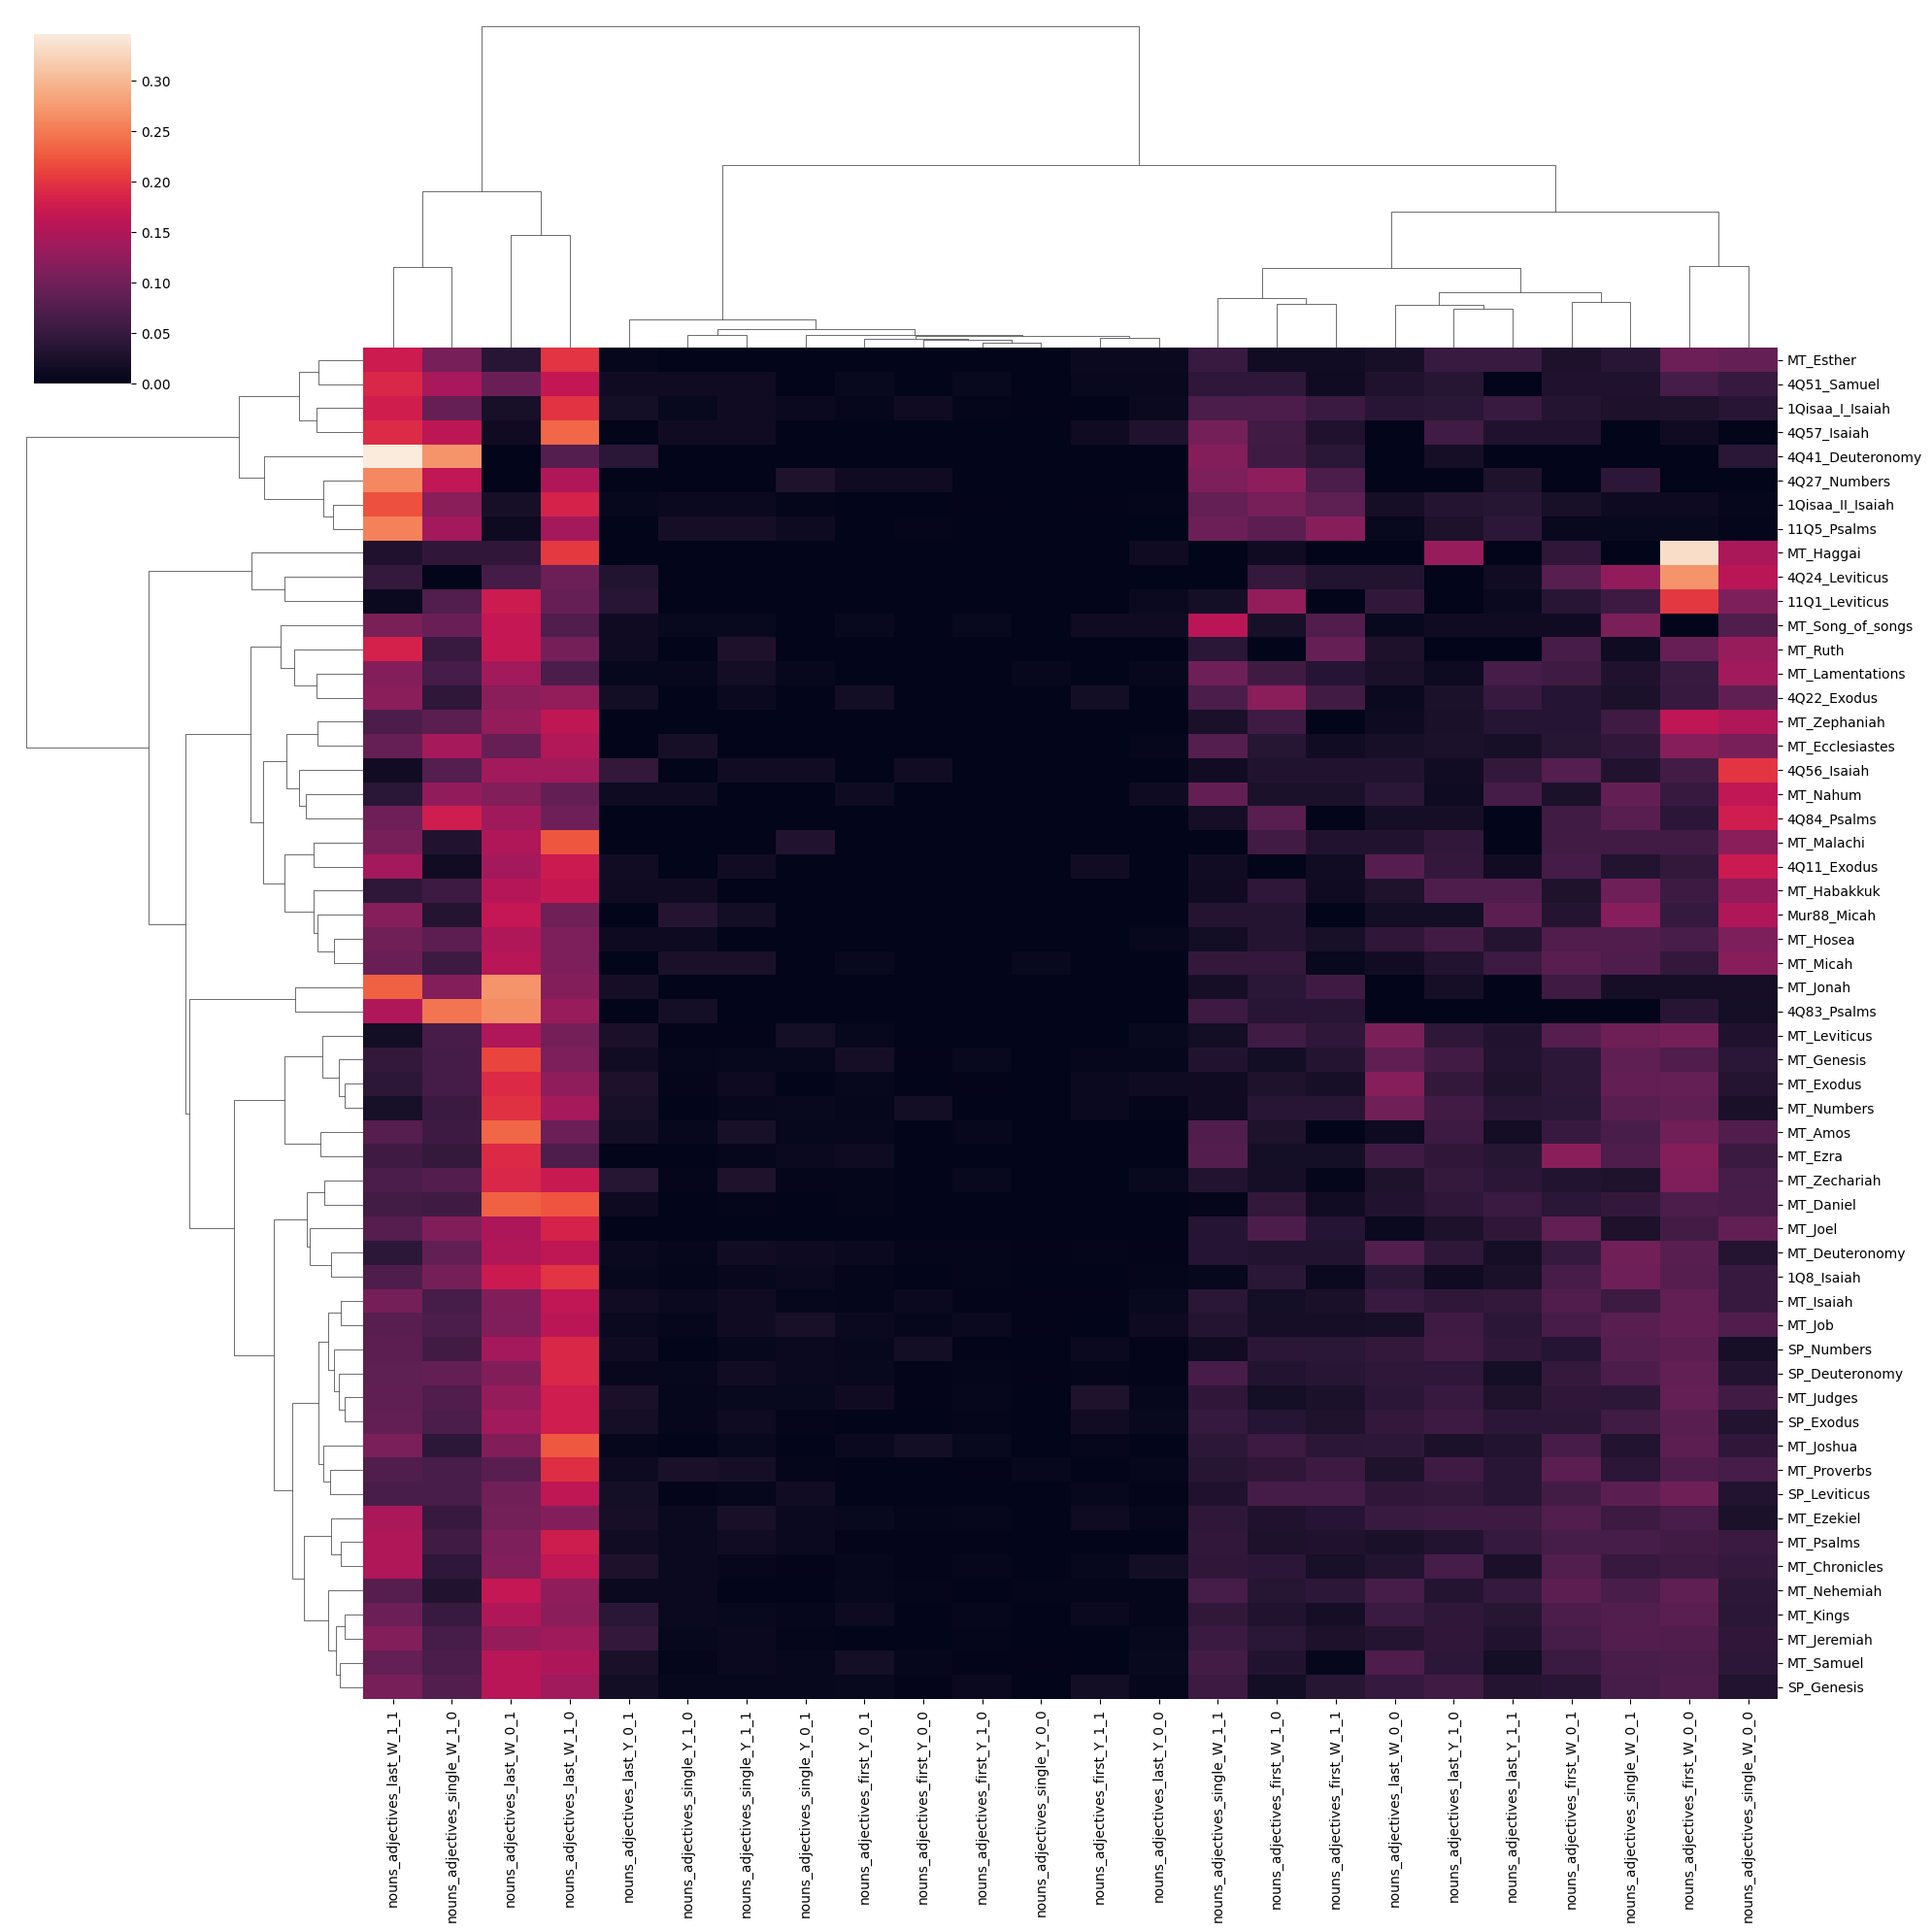

In [19]:
sns.clustermap(counts_norm_df_nouns_adjectives,
               figsize = (20, 20), 
               method='ward', 
               metric='euclidean')

plt.savefig(f'hierarch_clust_counts_norm_heatmap_nouns_adjectives_lex_cut_off{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')

# Only verbs

In [22]:
LEX_CUT_OFF = 4
DOCUMENT_CUT_OFF = 50
FEATURE_CUT_OFF = 10

files = [
         'infa_qal.csv',
         'infc_qal_lamed_he.csv', 
         'infc_qal_triliteral.csv', 
         'niph_hiph_pe_yod.csv', 
         'ptca_qal.csv', 
         'ptcp_qal.csv',
         'hiphil_triliteral_with_hireq.csv'
]

scroll_book_dict = import_data(path, files, False)
sorted_features, book_feature_counts = prepare_features(scroll_book_dict, LEX_CUT_OFF)
counts_df = prepare_features_in_df(DOCUMENT_CUT_OFF)
counts_df = remove_rare_features(counts_df, FEATURE_CUT_OFF)
counts_norm_df_verbs = divide_by_document_sums(counts_df)

infa_qal
infc_qal_lamed_he
infc_qal_triliteral
niph_hiph_pe_yod
ptca_qal
ptcp_qal
hiphil_triliteral_with_hireq


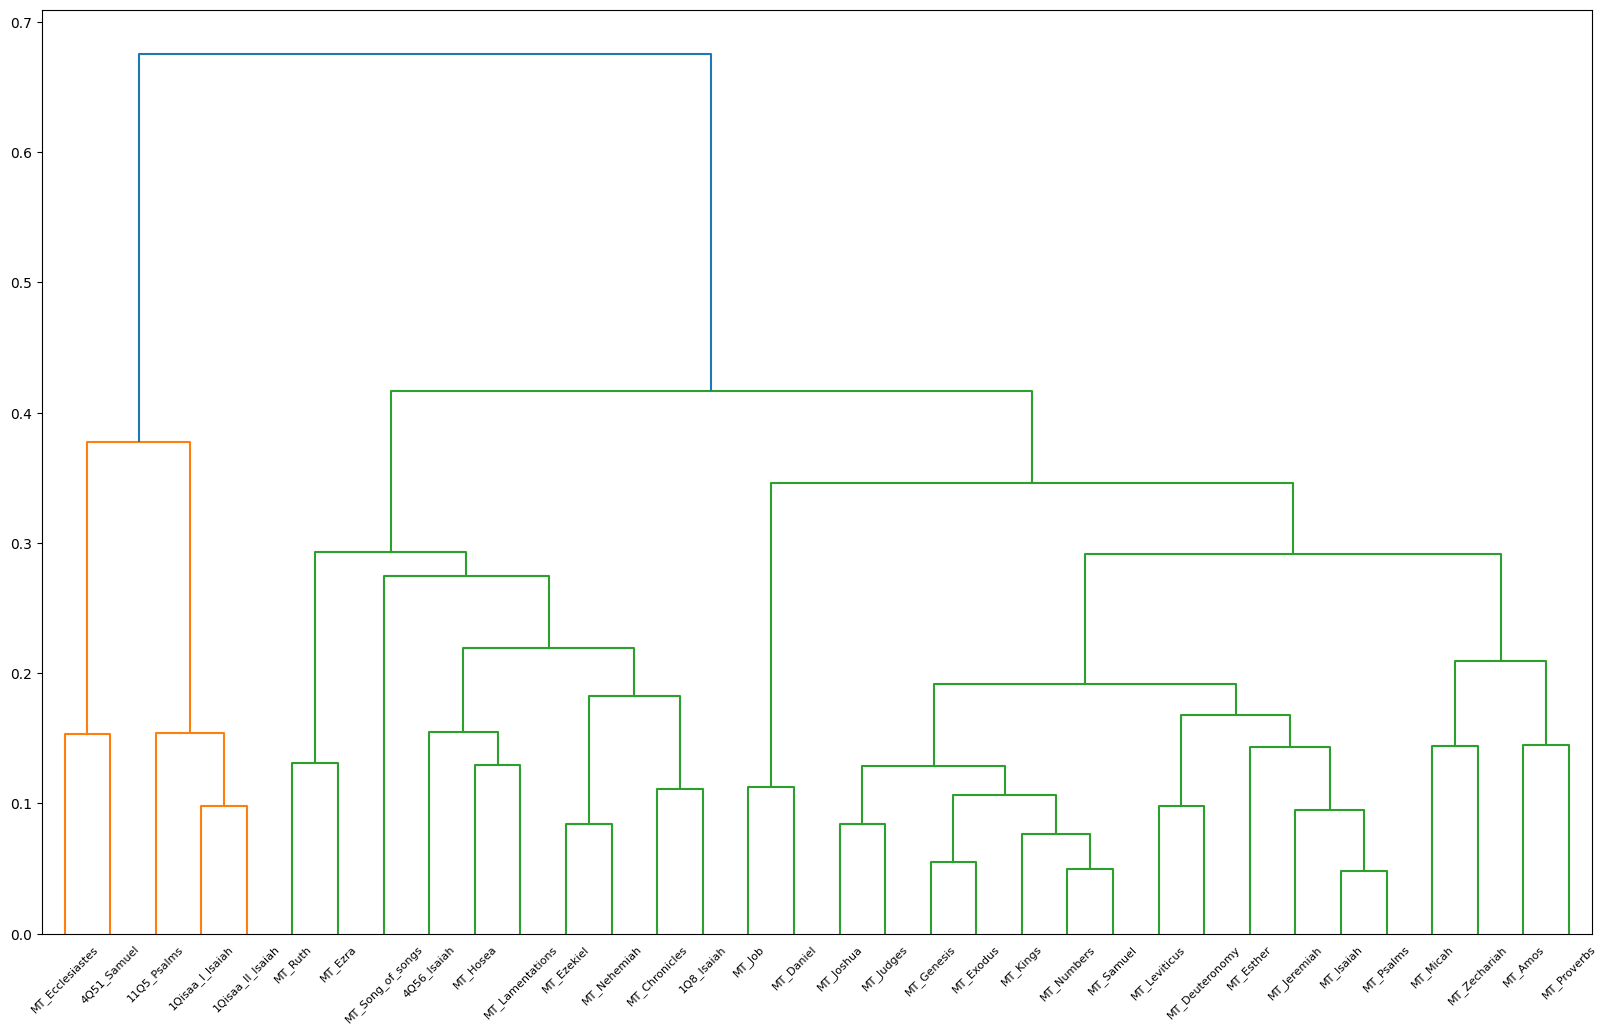

In [23]:
linkage_data = linkage(counts_norm_df_verbs, 
                       method='ward', 
                       metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts_norm_df_verbs.index)

plt.savefig(f'hierarch_clust_counts_norm_dendrogram_verbs_lex_cut_off_{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')

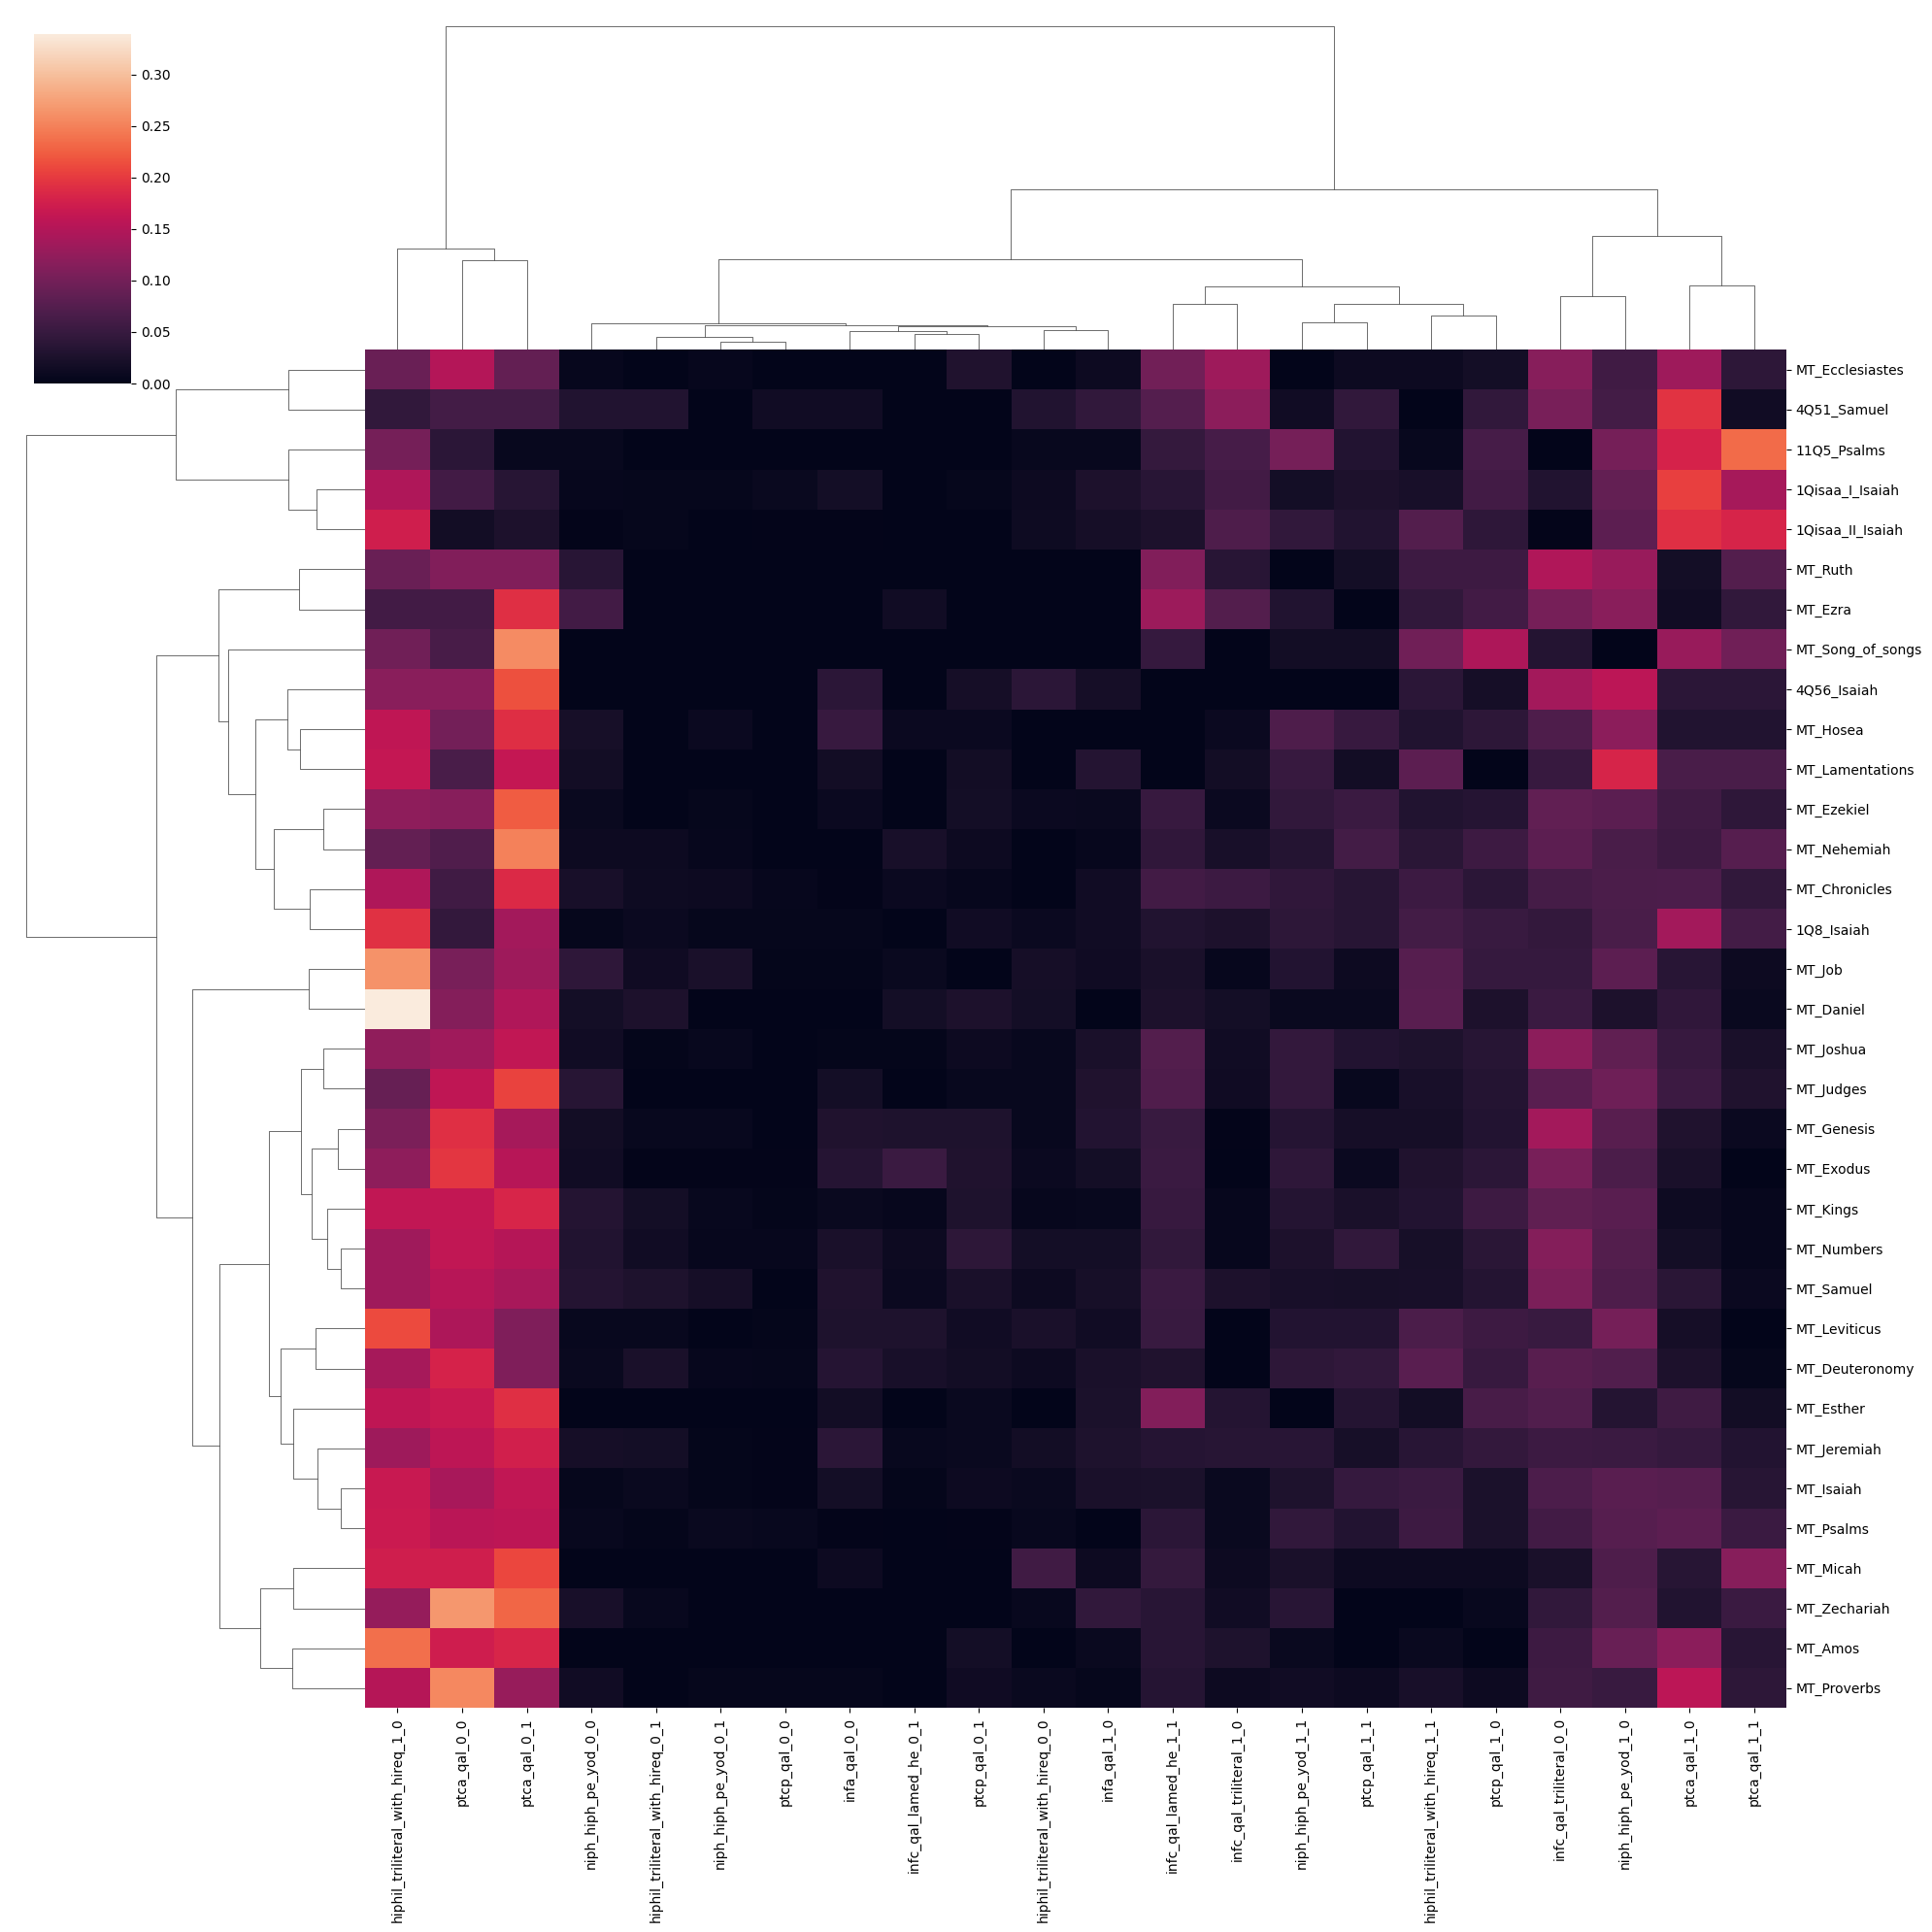

In [25]:
sns.clustermap(counts_norm_df_verbs,
               figsize = (20, 20), 
               method='ward', 
               metric='euclidean')

plt.savefig(f'hierarch_clust_counts_norm_heatmap_verbs_lex_cut_off_{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')

# All data

In [26]:
LEX_CUT_OFF = 10
DOCUMENT_CUT_OFF = 80
FEATURE_CUT_OFF = 10

files = [
         'nouns_adjectives.csv', 
         'infa_qal.csv',
         'infc_qal_lamed_he.csv', 
         'infc_qal_triliteral.csv', 
         'niph_hiph_pe_yod.csv', 
         'ptca_qal.csv', 
         'ptcp_qal.csv',
         'hiphil_triliteral_with_hireq.csv'
]

scroll_book_dict = import_data(path, files, False)
sorted_features, book_feature_counts = prepare_features(scroll_book_dict, LEX_CUT_OFF)
counts_df = prepare_features_in_df(DOCUMENT_CUT_OFF)
counts_df = remove_rare_features(counts_df, FEATURE_CUT_OFF)
counts_norm_df_all = divide_by_document_sums(counts_df)

nouns_adjectives
infa_qal
infc_qal_lamed_he
infc_qal_triliteral
niph_hiph_pe_yod
ptca_qal
ptcp_qal
hiphil_triliteral_with_hireq


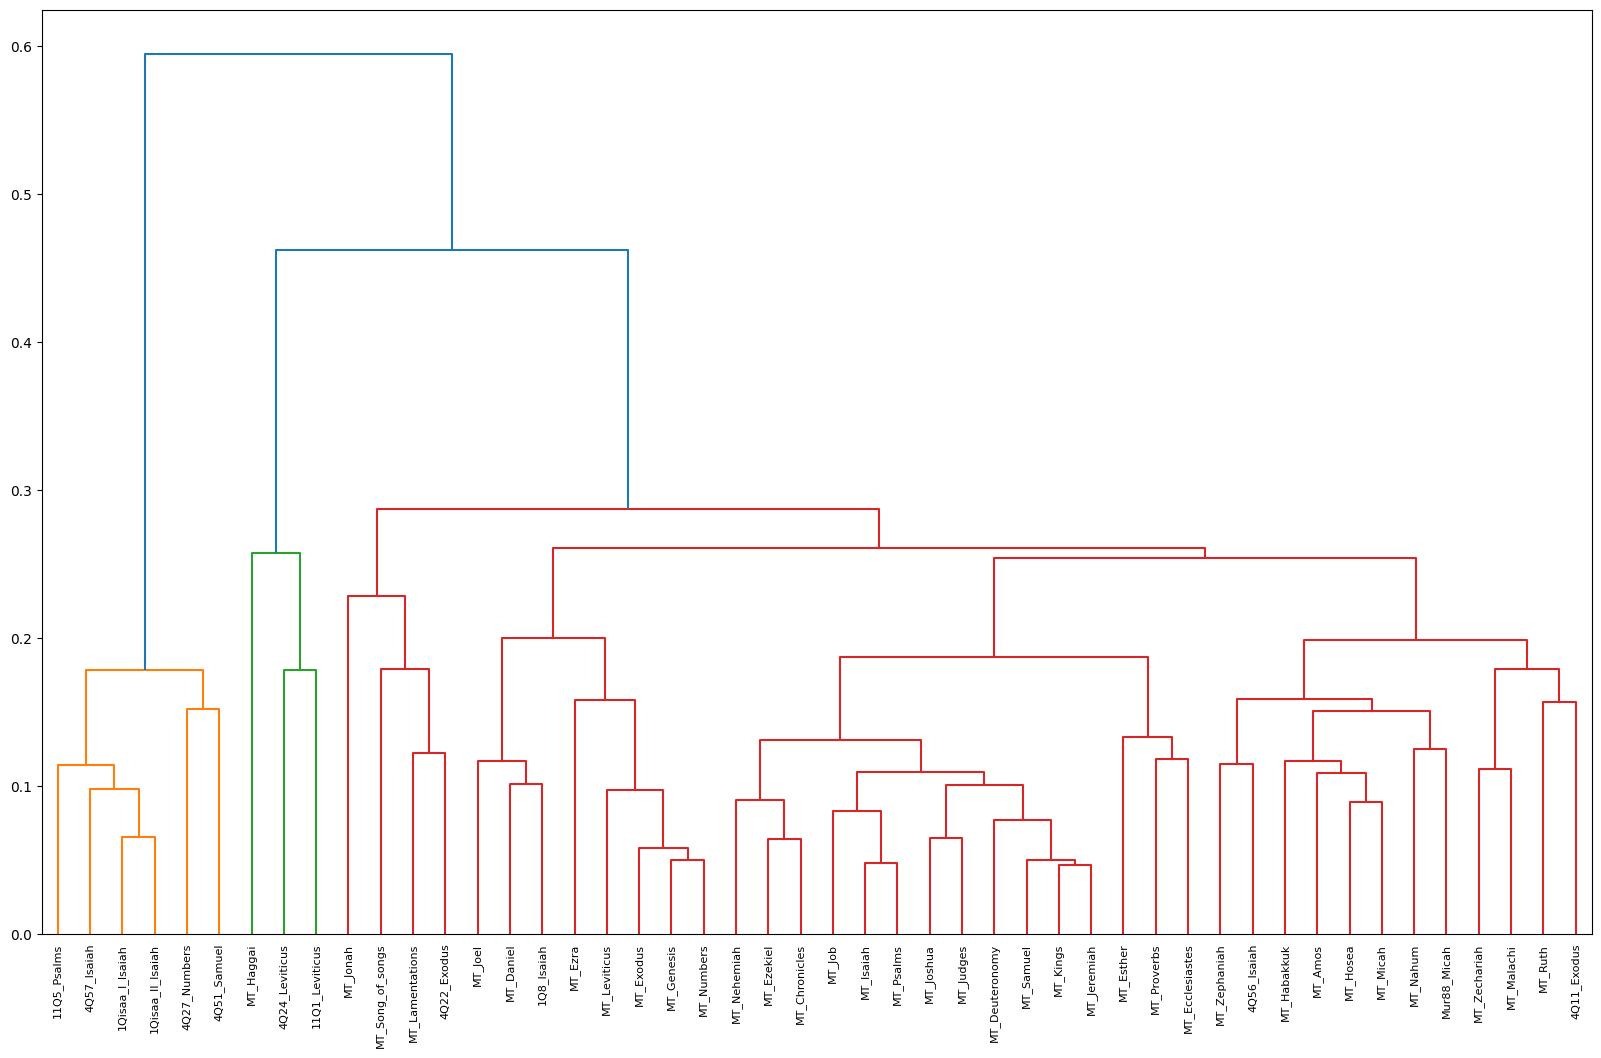

In [27]:
linkage_data = linkage(counts_norm_df_all, 
                       method='ward', 
                       metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts_norm_df_all.index)

plt.savefig(f'hierarch_clust_counts_norm_dendrogram_all_lex_cut_off_{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')

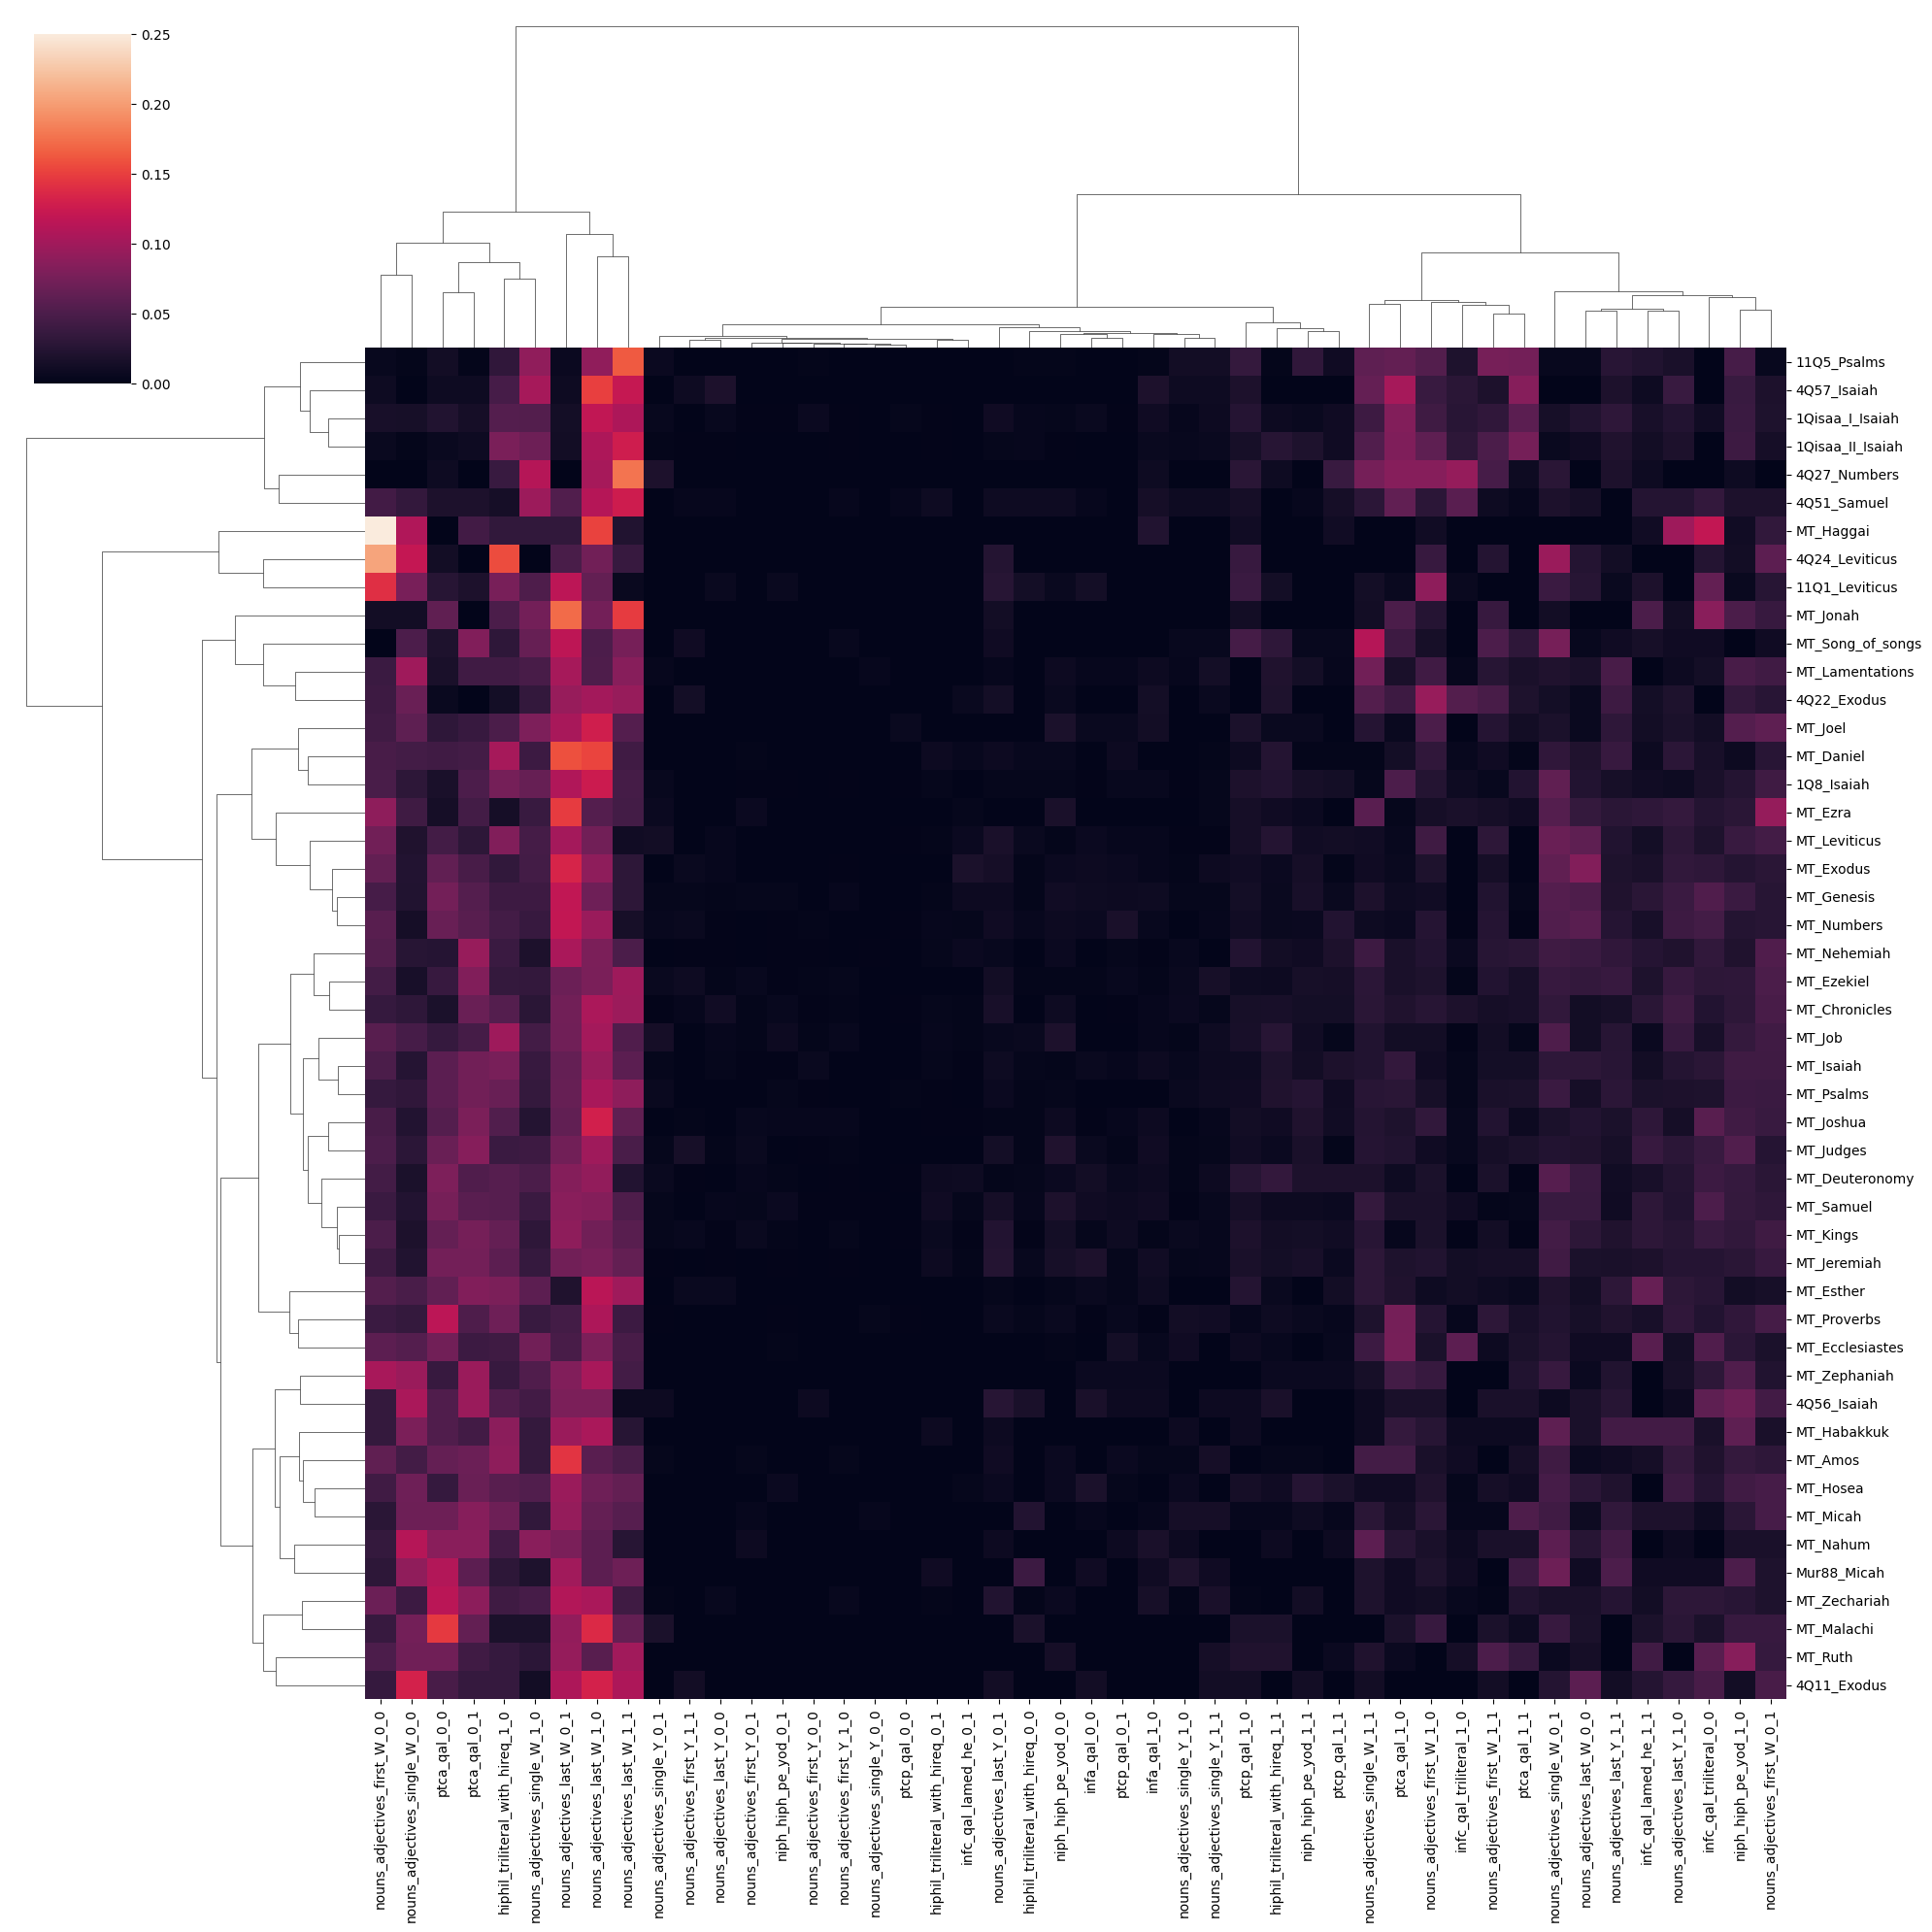

In [28]:
sns.clustermap(counts_norm_df_all,
               figsize = (20, 20), 
               method='ward', 
               metric='euclidean')

plt.savefig(f'hierarch_clust_counts_norm_heatmap_all_lex_cut_off_{LEX_CUT_OFF}_doc_cut_off{DOCUMENT_CUT_OFF}.png')